In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ElementObject import *
from scipy import optimize
from ShapeFunctions import *


In [14]:
ElType = 1
ElOrder = 1
n = 3
dim = 2

# DEFINE RANDOM ELEMENT
Xe = np.array([[-1, -1],[2,0],[0,3]])
#Xe = np.array([[-2, -0.5],[4,1],[0,3]])
Xe = np.array([[0,3],[-2,-3],[2,-2]])
Te = np.array([0,1,2])

Elem = Element(0,ElType,ElOrder,Xe,Te,None,None)

QuadratureOrder = 3
#### QUADRATURE TO INTEGRATE SURFACES (2D)
Xig2DFEM, Elem.Wg2D, Elem.Ng2D = GaussQuadrature(ElType,QuadratureOrder)
# EVALUATE REFERENCE SHAPE FUNCTIONS 
N, dNdxi, dNdeta = EvaluateReferenceShapeFunctions(Xig2DFEM, ElType, ElOrder, n)

# COMPUTE INTERFACE LINEAR APPROXIMATION
def interface(r):
    z = -r+1
    return z

def zedge(r,Xe,edge):
    # FUNCTION DESCRIBING THE RESTRICCION ASSOCIATED TO THE ELEMENT EDGE
    z = ((Xe[edge,1]-Xe[0,1])*r+Xe[0,1]*Xe[edge,0]-Xe[edge,1]*Xe[0,0])/(Xe[edge,0]-Xe[0,0])
    return z

def fun(r,Xe,edge):
    f = interface(r) - zedge(r,Xe,edge)
    return f

def InverseMapping(X, Xe):
    # DEFINE THE NONLINEAR SYSTEM 
    def fun(Xg, X, Xe):
        f = np.array([-X[0],-X[1]])
        for i in range(n):
            Nig, foo, foo = ShapeFunctionsReference(Xg,1, 1, i+1)
            f[0] += Nig*Xe[i,0]
            f[1] += Nig*Xe[i,1]
        return f
    # SOLVE USING NONLINEAR SOLVER
    Xg0 = np.array([1/4, 1/4])  # INITIAL GUESS FOR ROOT SOLVER
    sol = optimize.root(fun, Xg0, args=(X,Xe))
    #print(sol)
    Xg = sol.x
    return Xg

# COMPUTE PHYSICAL INTERFACE 
Elem.Xeint = np.zeros([2,2])
for i, edge in enumerate([1,2]):
    r0 = 0.5
    sol = optimize.root(fun, r0 , args=(Xe,edge))
    Elem.Xeint[i,:] = [sol.x, interface(sol.x)]
    
# DO TESSELLATION ON PHYSICAL ELEMENT AND GENERATE SUBELEMENTS
Elem.Xemod, Elem.Temod = Element.Tessellation(Mode=0,Xe=Elem.Xe,Xeint=Elem.Xeint)
Elem.Nsub = len(Elem.Temod[:,0])

Elem.SubElements = [Element(index = subelem, ElType = Elem.ElType, ElOrder = Elem.ElOrder,
                                    Xe = Elem.Xemod[Elem.Temod[subelem,:]],
                                    Te = Elem.Te,
                                    LSe = None,
                                    PHIe = None) for subelem in range(Elem.Nsub)]

# 1. MAPP PHYSICAL INTERFACE TO REFERENCE ELEMENT
XiintREF = np.zeros(np.shape(Elem.Xeint))
for i in range(len(Elem.Xeint[:,0])):
    XiintREF[i,:] = Elem.InverseMapping(Elem.Xeint[i,:])
      
# 2. DO TESSELLATION ON REFERENCE ELEMENT
XiREF = np.array([[1,0], [0,1], [0,0]])
XimodREF, TemodREF = Element.Tessellation(Mode=0,Xe=XiREF,Xeint=XiintREF)

# 3. MAP 2D REFERENCE GAUSS INTEGRATION NODES ON THE REFERENCE SUBELEMENTS AND EVALUATE REFERENCE SHAPE FUNCTIONS
for i, subelem in enumerate(Elem.SubElements):
    subelem.Xig2D = N @ XimodREF[TemodREF[i,:]]
    # EVALUATE REFERENCE SHAPE FUNCTIONS ON MODIFIED REFERENCE QUADRATURE
    subelem.N, subelem.dNdxi, subelem.dNdeta = EvaluateReferenceShapeFunctions(subelem.Xig2D, ElType, ElOrder, n)
    # MAPP MODIFIED REFERENCE QUADRATURE ON PHYSICAL ELEMENT
    subelem.Xg2D = subelem.N @ Elem.Xe
    #subelem.Xg2D = N @ subelem.Xe

/tmp/ipykernel_125996/1950177536.py:55: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Elem.Xeint[i,:] = [sol.x, interface(sol.x)]


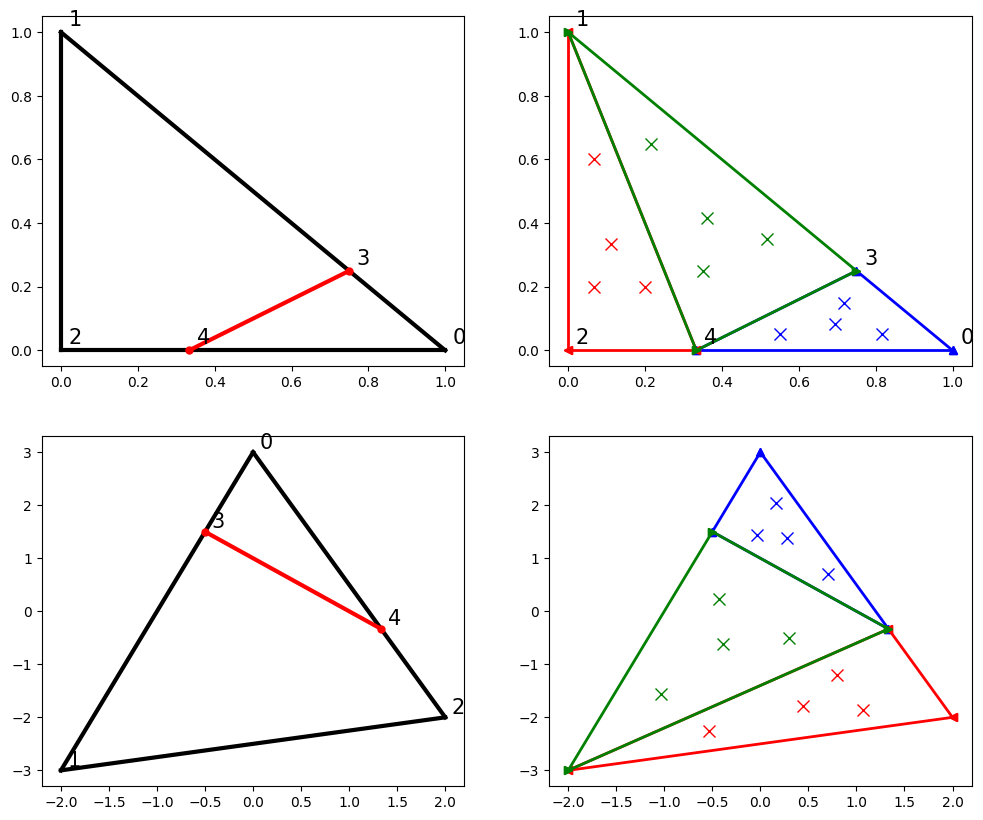

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(12,10))

###### FIRST ROW FIGURES: REFERENCE SPACE
# PLOT REFERENCE INTERFACE LINEAR APPROXIMATION
for i in range(n):
    axs[0,0].plot([XiREF[int(Te[i])-1,0], XiREF[int(Te[int((i+1)%n)])-1,0]], 
            [XiREF[int(Te[i])-1,1], XiREF[int(Te[int((i+1)%n)])-1,1]], color='black', linewidth=3)
axs[0,0].plot(XiintREF[:,0], XiintREF[:,1], '.', color='red',markersize=10)
axs[0,0].plot(XiintREF[:,0], XiintREF[:,1],color='red', linewidth=3)
d = 0.02
for i in range(len(XimodREF[:,0])):
    axs[0,0].text(XimodREF[i,0]+d,XimodREF[i,1]+d,str(i),fontsize=15)

# PLOT TESSELLATION ON PHYSICAL ELEMENT
colorlist = ['blue', 'red', 'green']
markerlist = ['^', '<', '>']
for i in range(Elem.Nsub):
    for j in range(n):   # plot edges
        axs[0,1].plot([XimodREF[TemodREF[i,j],0], XimodREF[TemodREF[i,int((j+1)%n)],0]], [XimodREF[TemodREF[i,j],1], XimodREF[TemodREF[i,int((j+1)%n)],1]],
                 linestyle = '-', color = colorlist[i], linewidth=2 , marker=markerlist[i])
# PLOT NODE NUMERATION
d = 0.02
for i in range(len(XimodREF[:,0])):
    axs[0,1].text(XimodREF[i,0]+d,XimodREF[i,1]+d,str(i),fontsize=15)
# PLOT MODIFIED REFERENCE GAUSS INTEGRATION NODES
for i, subelem in enumerate(Elem.SubElements):
    axs[0,1].plot(subelem.Xig2D[:,0],subelem.Xig2D[:,1],'x',color=colorlist[i], markersize = 8)
    
###### SECOND ROW FIGURES: PHYSICAL SPACE
# PLOT PHYSICAL INTERFACE LINEAR APPROXIMATION
for i in range(n):
    axs[1,0].plot([Xe[int(Te[i])-1,0], Xe[int(Te[int((i+1)%n)])-1,0]], 
            [Xe[int(Te[i])-1,1], Xe[int(Te[int((i+1)%n)])-1,1]], color='black', linewidth=3)

axs[1,0].plot(Elem.Xeint[:,0], Elem.Xeint[:,1], '.', color='red',markersize=10)
axs[1,0].plot(Elem.Xeint[:,0], Elem.Xeint[:,1],color='red', linewidth=3)
# PLOT NODE NUMERATION
d = 0.07
for i in range(len(Elem.Xemod[:,0])):
    axs[1,0].text(Elem.Xemod[i,0]+d,Elem.Xemod[i,1]+d,str(i),fontsize=15)

# PLOT TESSELLATION ON PHYSICAL ELEMENT
for i, subelem in enumerate(Elem.SubElements):
    for j in range(n):   # plot edges
        axs[1,1].plot([subelem.Xe[j,0], subelem.Xe[int((j+1)%n),0]], [subelem.Xe[j,1], subelem.Xe[int((j+1)%n),1]],
                 linestyle = '-', color = colorlist[i], linewidth=2 , marker=markerlist[i])
# PLOT MODIFIED PHYSICAL GAUSS INTEGRATION NODES
for i, subelem in enumerate(Elem.SubElements):
    axs[1,1].plot(subelem.Xg2D[:,0],subelem.Xg2D[:,1],'x',color=colorlist[i], markersize = 8)
